# GMM

Reference: ReviewOfSomeEconometrics180827.pdf, Andrews, D. W. (1991): Heteroskedasticity and autocorrelation consistent covariance matrix estimation.

Content:

* (1) [Estimation](#section1) ($q=k$)
* (2) [Linear models](#section2)
* (2.1) [OLS as GMM](#section21)
* (2.2) [SURE](#section22)
* (3) [Hansen-Singleton](#section3) ($q>k$)
* (4) [Cross section](#section4)

<a id='section1'></a>
## (1) Estimation
Estimation with $q=k$. This example make use of results in ReviewOfSomeEconometrics180827.pdf, all notation is the same

Estimating mean $\mu$ and variance $\sigma^2$ with GMM,  with different standard errors

In [1]:
using Statistics: mean, var
using Distributions: Normal
using LinearAlgebra: Diagonal, diag
using Plots: plot
using ForwardDiff
using Random

Random.seed!(123)

T = 100
v = rand(Normal(1.5, 1), T)

# The parameter vector is θ = [μ σ²]
# And the moment conditions are
function f(v, θ)
    [v .- θ[1]  (v .- θ[1]).^2 .- θ[2]]
end     

function g(θ, v)
    mean(f(v, θ), dims=1)
end

# This system is exactly identified with solution sample
# mean and variance:
μ = mean(v)
σ² = var(v, corrected=false)

θhat =  [μ; σ²]
# So the average moment conditions are of course exactly zero
g(θhat, v)

1×2 Array{Float64,2}:
 8.77076e-17  7.88258e-17

In [2]:
# The gradient matrix of the moment conditions is
D = ForwardDiff.jacobian(θ -> g(θ, v), θhat)

2×2 Array{Float64,2}:
 -1.0           0.0
 -1.62093e-16  -1.0

In [3]:
# Which for the given `f`, if you write 
# out the analytical expression, is simply
# D₀ = - Diagonal(ones(2))

# And given no serial correlation, the covariance 
# matrix S₀ is equal to Γ₀ (slides: p 32)
S = f(v, θhat)' * f(v, θhat) / T

vcv = inv(D' * inv(S) * D) / T  # Which simplifies to: S₀ / T 

# Standard errors
sqrt.(diag(vcv)) 

2-element Array{Float64,1}:
 0.11228280164716382
 0.1972469414860444 

#### Assuming $v$ is normal

In [4]:
# Writing out the analytical expression for
# S₀ = E( f(v, θ)' * f(v, θ) ) leads to
S₀ = [θhat[2] 0;
      0  2*θhat[2]^2] 

vcv_normal = inv(D' * inv(S₀) * D) / T 

# Standard errors, which if T → ∞ coincides
# with those above
sqrt.(diag(vcv_normal))

2-element Array{Float64,1}:
 0.11228280164716382
 0.17829595021816466

#### Newey and West standard errors

In [5]:
# In: `src/NW.jl`
function NW(F,M)                                # Newey and West (1987)
    T = size(F,1)                               # number of observations
    F = F .- mean(F,dims=1)                     # demean
    S = F'F/T                                   # lag zero
    for j = 1:M                                 # lags -j to +j
        Gamma_j = F[j+1:T,:]'F[1:T-j,:]/T
        S = S  +  ( 1 - j/(M+1) )*(Gamma_j + Gamma_j')
    end

    return S
end

# Gives standard errors
sqrt.(diag(NW(f(v, θhat), 1) / T))

2-element Array{Float64,1}:
 0.10978807215677272
 0.20238250307276232

#### Different weighting kernels illustrated
Normalized to have the same variance, reference: Andrews (1991)

In [6]:
x = 0.01:0.01:3.5

function kernelweight(kind, x)
    if kind == "truncated"
        x = 2*x
        k = Float64.(abs.(x) .<= 1)
        k[k .== 0] .= NaN
        return k
    elseif kind == "bartlett"
        x = 2 * x / 3
        k = abs.(x) .<= 1
        k = (1 .- x) .* k
        k[k .== 0] .= NaN
        return k
    elseif kind == "parzen"
        x = 0.539285 * x
        k1 = 1 .- 6 * x.^2 .+ 6 * abs.(x).^3
        k1[x .> 0.5] .= 0
        k2 = 2 * (1 .- abs.(x)).^3
        k2[x .<= 0.5] .= 0
        k2[x .> 1] .= 0
        k = k1 + k2
        k[k .== 0] .= NaN
        return k
    elseif kind == "quadratic-spectral"
        k = (25 ./ (12*π^2 * x.^2)) .* ( sin.(6*π * x/5) ./
            (6*π * x/5) .- cos.(6*π * x/5) )
        return k
    end
    
end

kernelweight (generic function with 1 method)

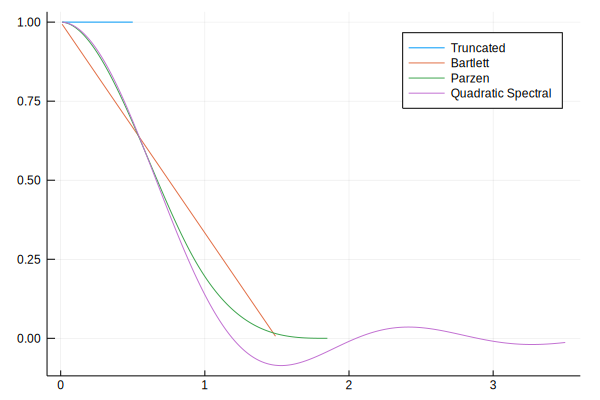

In [7]:
k1 = kernelweight("truncated", x) 
k2 = kernelweight("bartlett", x) 
k3 = kernelweight("parzen", x) 
k4 = kernelweight("quadratic-spectral", x) 

plot(x, [k1 k2 k3 k4],
    label = ["Truncated", "Bartlett",
            "Parzen", "Quadratic Spectral"])

<a id='section2'></a>
## (2) Linear models

<a id='section21'></a>
#### (2.1) OLS as GMM

In [8]:
include("src/NW.jl")
using Statistics: mean
using Distributions: Normal, Chisq, ccdf
using LinearAlgebra: qr, diag, Diagonal
using Random

Random.seed!(123)

T = 100
K = 3
θ = [0.4; 0.6; 0.8]
X = rand(Normal(), T, K)
e = rand(Normal(), T)

y = X * θ + e;

The GMM estimator is the familiar LS estimator

$\theta =(X'X)^{-1} X'y$

In [9]:
θhat = inv(X'X)X'*y

3-element Array{Float64,1}:
 0.5611580939913476
 0.5118736249879364
 0.7940476221997095

Using the same notation as in the slides (Econometrics Review p. 42):

In [10]:
inv(mean([X[t, :]X[t, :]' for t in 1:T])) * mean([X[t, :]y[t] for t in 1:T])

3-element Array{Float64,1}:
 0.5611580939913478
 0.5118736249879364
 0.7940476221997097

A quick digression: in practice this is obtained by solving the system 

$X'X\theta = X'y$

through a factorization of $X'X$, most commonly the [QR](https://en.wikipedia.org/wiki/QR_decomposition) decomposition: 

$X'X = QR$, where Q is an orthogonal matrix (i.e. no inverse is needed) leading to the following:

$R\theta = Q'X'y$

Where R is upper triangular, which means $\theta$ can be obtained by backward substitution:



In [11]:
QR = qr(X'X)
Qr = QR.Q
Rr = QR.R;

The rhs of the equation:

In [12]:
Qr'X'y

3-element Array{Float64,1}:
 -50.42575307525098
 -37.99542306275191
  84.29857896560684

And the lhs:

In [13]:
Rr

3×3 Array{Float64,2}:
 -127.658  -11.7642   34.2955
    0.0    -99.3057   16.166 
    0.0      0.0     106.163 

Which means that $\hat \theta_3$ is

In [14]:
84.29857896560684 / 106.163 

0.7940485759219957

Which is used to solve for $\hat \theta_2$, etc. Since this is a common procedure, a shortcut is the backslash operator `\`:

In [15]:
X \ y

3-element Array{Float64,1}:
 0.5611580939913474
 0.5118736249879368
 0.7940476221997095

Why would this be necessary: an example where $X'X$ is close to singular:

In [16]:
tmp = X[:, 2]
X[:, 2] = X[:, 1] * 1e-6
y = X * θ + e;

In [17]:
# The inverse solution:
inv(X'X)X'*y

3-element Array{Float64,1}:
      1.1796348172207438
 703237.7227102472      
      0.8007093681191334

In [18]:
# The linear system solution obtained with a numerically 
# stable factorization:
X \ y

3-element Array{Float64,1}:
 0.5579839604186029  
 5.579839604186028e-7
 0.8007093681191332  

In [19]:
X[:, 2] = tmp
y = X * θ + e;

#### (2.2) Standard errors

In [20]:
# With OLS assumptions:
Σxx = X'X/T
D = - Σxx;

ε = y - X * θhat
σ² = mean(ε.^2)

S = σ² * Σxx

vcv_normal = inv(D' * inv(S) * D) / T 

sqrt.(diag(vcv_normal))

3-element Array{Float64,1}:
 0.0849938980566576 
 0.0949726310242743 
 0.09089056626918658

In [21]:
# Which simplifies to the familiar OLS SE formula:
sqrt.(diag(σ² * inv(X'X)))

3-element Array{Float64,1}:
 0.08499389805665758
 0.0949726310242743 
 0.09089056626918658

In [22]:
# Heteroscedasticity robust (White) SEs
lag = 0
S = NW(ε .* X, lag) # From `src/NW.jl`
# Same as: S = X'Diagonal(ε.^2)X / T

vcv_white = inv(D' * inv(S) * D) / T 
sqrt.(diag(vcv_white))

3-element Array{Float64,1}:
 0.06975507867516514
 0.10370646726550065
 0.09123132606328757

In [23]:
# Newey and West SEs, one lag
lag = 1
S = NW(ε .* X, 1)

vcv_nw = inv(D' * inv(S) * D) / T 
sqrt.(diag(vcv_nw))

3-element Array{Float64,1}:
 0.0699864330646872 
 0.10622005436643957
 0.09967347868596375

#### (2.3) Wald test

Testing $\theta_1 = 0$

In [24]:
R = [1 0 0]
r = [0]

wald = (r - R * θhat)' * inv(R * vcv_nw * R') * (r - R * θhat)

ccdf(Chisq(length(r)), wald)

1.0739492309441184e-15

<a id='section22'></a>
#### (2.4) SURE
Jointly estimating multiple linear models (N) with the same K regressors

In [25]:
include("src/NW.jl")
using Distributions: Normal, Chisq, ccdf
using LinearAlgebra: diag, Diagonal
using Random

Random.seed!(123)

T = 1000
K = 3
N = 2
θ₁ = [0.4; 0.6; 0.8]
θ₂ = [1.4; 1.6; 1.8]
Θ = [θ₁';  θ₂']
X = rand(Normal(), T, K)
e = rand(Normal(), T, N)

Y = X * Θ' + e

# Stacked estimation
Σxx = kron(X'X/T, Diagonal(ones(N)))
Σxy = vec(Y'X/T)

vecΘ = inv(Σxx) * Σxy

6-element Array{Float64,1}:
 0.3735487753704459
 1.370614740195365 
 0.63512311772765  
 1.591882797707041 
 0.8519109324658157
 1.7284766205987312

In [26]:
# Same as
vec((X \ Y)')

6-element reshape(::LinearAlgebra.Adjoint{Float64,Array{Float64,2}}, 6) with eltype Float64:
 0.37354877537044595
 1.370614740195364  
 0.6351231177276497 
 1.5918827977070409 
 0.8519109324658156 
 1.7284766205987325 

In [27]:
Θhat = reshape(vecΘ, N, K)

2×3 Array{Float64,2}:
 0.373549  0.635123  0.851911
 1.37061   1.59188   1.72848 

#### (2.5) Standard errors

In [28]:
# With OLS assumptions:
D = kron(-Σxx, Diagonal(ones(N)))
ε = Y - X * Θhat'
Σεε = ε'ε / T

S = kron(Σxx, Σεε)
vcv_normal = inv(D' * inv(S) * D) / T 
# Simplifies to
# vcv_normal = kron(inv(Σxx)/T, Σεε)
se_normal = sqrt.(diag(vcv_normal))

12-element Array{Float64,1}:
 0.03177781442948086 
 0.03304868499596468 
 0.03177781442948086 
 0.03304868499596468 
 0.03216372100230665 
 0.033450024892750035
 0.03216372100230665 
 0.033450024892750035
 0.033327727187850584
 0.03466058246097938 
 0.033327727187850584
 0.03466058246097938 

In [29]:
reshape(se_normal, N*N, K)[1:N,:]

2×3 Array{Float64,2}:
 0.0317778  0.0321637  0.0333277
 0.0330487  0.03345    0.0346606

In [30]:
# Heteroscedasticity robust (White) SEs
lag = 0
D = kron(Diagonal(ones(N)), -X'X/T)
m = kron(ones(N)', X) .* reshape(repeat(ε, K), T, N*K)
S = NW(m, lag) # From `src/NW.jl`
vcv_white = inv(D' * inv(S) * D) / T

se_white = sqrt.(diag(vcv_white))
reshape(se_white, N, K)

2×3 Array{Float64,2}:
 0.0310312  0.0347822  0.0330711
 0.0327166  0.0344842  0.0327271

In [31]:
# Newey and West SEs, one lag
lag = 1
S = NW(m, lag) # From `src/NW.jl`
vcv_nw = inv(D' * inv(S) * D) / T

se_nw = sqrt.(diag(vcv_nw))
reshape(se_nw, N, K)

2×3 Array{Float64,2}:
 0.0308449  0.035366   0.0331532
 0.0331029  0.0344198  0.0330897

#### (2.6) Wald test
Testing $\theta^1_1 = \theta^2_1 = 0$

In [32]:
R = [1 0 0 0 0 0;
     0 1 0 0 0 0]
r = [0; 0]

wald = (r - R * vecΘ)' * inv(R * vcv_nw * R') * (r - R * vecΘ)
ccdf(Chisq(length(r)), wald)

0.0

<a id='section3'></a>
## (3) Hansen-Singleton
Estimation with $q > k$: 2-step and continuous updating 

Example from Assignment 3.3: estimate $\delta$ and $\gamma$, with random data (notation same as in slides)

In [33]:
include("src/NW.jl")
using Statistics: mean
using Optim: optimize
using LinearAlgebra: Diagonal, diag
using Distributions: MvNormal, MvLogNormal
using ForwardDiff
using Random

Random.seed!(12)

δ = 0.8
γ = 0.5
vcv = [1 0.2 0
       0.2 1 0
       0 0 1]
avg = vec([(log(δ) + γ^2/2)/γ;
            γ*0.2 - 1/2 ;
            0])
T = 1000
x = rand(MvLogNormal(MvNormal(avg, vcv)), T)'
Δc = x[:, 1]
r = x[:, 2]
rf = x[:, 3]

# E(δΔc⁻γ R) ≈ 1
δ * mean(Δc.^(-γ) .* r)

1.0360166921758636

In [34]:
# Data
v = [Δc[2:end] r[2:end]]
# Instruments
z = [ones(T-1) Δc[1:end-1] r[1:end-1] - rf[1:end-1]] ;

Define the moment conditions and objective functions

In [35]:
# The moment conditions, θ = [δ γ]
function f(v, z, θ)
    δ = θ[1]
    γ = θ[2]
    Δc = v[:, 1]
    R = v[:, 2:end]
    
    nz = size(z, 2)
    nr = size(R, 2)
    
    # (δΔc^⁻γ R - 1)z
    kron(ones(nz)', (δ * Δc.^(-γ) .* R .- 1)) .*
        kron(ones(nr)', z)
end

function g(θ, v, z)
    mean(f(v, z, θ), dims=1)
end

function Q(θ, W, v, z)
    (g(θ, v, z) * W * g(θ, v, z)')[1]
    # Why [1]: A one-element array is treated
    # differently than a scalar
end

Q (generic function with 1 method)

2-step estimation

In [36]:
function twostepGMM(θ₀, nwlag, v, z)
    k = length(θ₀)
    q = size(g(ones(k), v, z), 2)
    W₁ = Diagonal(ones(q))
    
    # First step
    θ₁ = optimize(θ -> Q(θ, W₁, v, z), θ₀).minimizer
    S₂ = NW(f(v, z, θ₁), nwlag)
    W₂ = inv(S₂)
    # Second step
    θhat = optimize(θ -> Q(θ, W₂, v, z), θ₁).minimizer
    S = NW(f(v, z, θhat), nwlag)
    
    θhat, S
end

# Starting values
θ₀ = ones(2)
nwlag = 1

θhat, S = twostepGMM(θ₀, nwlag, v, z)
θhat

2-element Array{Float64,1}:
 0.6950242601021548
 0.6740912550145396

Continuous updating estimation (estimate both $\theta$ and $W$). We can do this by defining a new function where $W$ is defined implicitly by $\theta$:

In [37]:
function continuousGMM(θ₀, nwlag, v, z)
    
    θhat = optimize(
            θ -> Q(θ, inv(NW(f(v, z, θ), nwlag)), v, z),
            θ₀).minimizer
    
    θhat, NW(f(v, z, θhat), nwlag)
end

θhat, S = continuousGMM(θ₀, nwlag, v, z);
θhat

2-element Array{Float64,1}:
 0.6684214453198369
 0.7324625119719703

Standard errors

In [38]:
D = ForwardDiff.jacobian(θ -> g(θ, v, z), θhat)
vcv_nw = inv(D' * inv(S) * D) / T

sqrt.(diag(vcv_nw))

2-element Array{Float64,1}:
 0.19439969472023166
 0.399099394224834  

<a id='section4'></a>
## (4) Cross section

In [39]:
# #Magnus assignment 4 data double check
# using DelimitedFiles
# d = readdlm("../../../Data/FamaFrench5Factors.csv",';')[2:end, 1:8]
# RF = d[:, 8] 
# Rm = d[:, 3] * 1.0
# Y = readdlm("../../../Data/FamaFrench5x5.csv",';')[2:end, 3:27]
# Y = Y .- RF
# T, N = size(Y)
# X = [ones(T) Rm]
# K = size(X, 2)

The cross section with 10 assets and one factor (a constant is included in all examples): 

* GRS 
* Fama-MacBeth
* Shanken standard error correction
* Joint test of zero pricing errors (GMM)

In [40]:
include("src/NW.jl")
using Statistics: mean, std
using LinearAlgebra: pinv, diag, Diagonal
using Distributions: Normal, FDist, Chisq, ccdf
using Random

Random.seed!(123)

# Simulated CAPM 
T = 500
N = 10
betas = rand(Normal(), N)
Rm = rand(Normal(0.05), T) # The factor
Y = Rm .* betas' + rand(Normal(), T, N) # Test assets
X = [ones(T) Rm] 
K = size(X, 2)

2

GRS

In [41]:
B = X \ Y
ε = Y -  X * B

F = kron(ones(N)', X) .* reshape(repeat(ε, K), T, N*K)

α = B[1, :]
Σ = F[:, 1:2:N*2]' * F[:, 1:2:N*2] / T
Σf = (X[:, 2] .- mean(X[:, 2]))' * (X[:, 2] .- mean(X[: ,2])) / T

SharpeRatioSq = mean(X[:, 2])' * inv(Σf) * mean(X[:, 2])
GRS = ((T-N-K+1) / N) * α' * inv(Σ) * α / (1 + SharpeRatioSq)

# Test statistic and p-value
GRS , ccdf(FDist(N, T-N-K+1), GRS)

(1.4205913842054843, 0.16769835038081773)

Fama-MacBeth

In [42]:
Beta = B[2, :]
EHat = Y -  X * B
LambdaMat = zeros(T, K)
EMat = zeros(T, N)
Xt = [ones(N) Beta]
for t in 1:T
    Yt = Y[t, :]
    LambdaMat[t, :] = Xt \ Yt
    EMat[t, :] = Yt - Xt*LambdaMat[t, :]
end

Lambda = mean(LambdaMat, dims=1)
# Which, since the betas are constant, is the same as:
# Xt \ mean(Y, dims=1)'

1×2 Array{Float64,2}:
 -0.0230561  0.125899

Fama-MacBeth SEs

In [43]:
std(LambdaMat, dims=1, corrected=false) / sqrt(T)

1×2 Array{Float64,2}:
 0.017099  0.0504892

Shanken SEs (generated regressors correction)

In [44]:
Sigma = EHat' * EHat / T
SigmaF = (X[:, 2] .- mean(X[:, 2]))' * (X[:, 2] .- mean(X[:, 2])) / T
Shanken = 1 .+ Lambda[2:K]' * inv(SigmaF) * Lambda[2:K]

vcvShanken = (inv(Xt' * Xt) * Xt' * Sigma * Xt * inv(Xt' * Xt) * Shanken  .+
             [0 zeros(K-1); zeros(K-1) SigmaF]) / T

sqrt.(diag(vcvShanken))

2-element Array{Float64,1}:
 0.017219217568549546
 0.050531349687252085

Test of zero pricing errors (GMM Magnus Style)

In [45]:
Ythat = Xt * Lambda' ;
Z = X
SigmaZZ = kron((Z' * Z / T), Diagonal(ones(N)))
SigmaZY = vec(Y' * Z / T)
B = inv(SigmaZZ) * SigmaZY
B = [B; Lambda']
F = zeros(T, N*K+N)
for j in 1:N
    for k in 0:(K-1)
        Bk = collect(10:N:size(F, 2))[1:2]
        F[:, j+k*N] = (Y[:, j] - Z * B[Bk]) .* Z[:, k+1]
    end
end
F[:, N*K+1:N*K+N] .= Y .- Ythat'

# Selection matrix
A = [Diagonal(ones(N*K)) zeros(N*K, N);
     zeros(K, N*K) [ones(1, N) ; Beta']
    ]

S = NW(F, 1)

D = [kron(Z' * Z / T, Diagonal(ones(N))) zeros(N*K, K) 
     zeros(N, N*K) -ones(N, 1) -Beta]

CovB = inv(A*D) * A * S * A' * inv(A*D)' / T

G = mean(F, dims=1)';

CovG = (Diagonal(ones(N*(K+1))) - D * inv(A*D) * A) * S * 
        (Diagonal(ones(N*(K+1))) -  D * inv(A*D) * A)'  / T

J = (G' * pinv(CovG) * G)[1]

# Test statistic and p-value
J, ccdf(Chisq(N-K+1), J)

(7.402960069215318, 0.5952420099818202)